## 1. Descrizione del problema

Un'azienda che opera nel campo del fashion e vende parte dei suoi prodotti online tramite il proprio e-commerce, ci chiede di realizzare un modello in grado di quantificare, sulla base della composizione del carrello e di alcune caratteristiche del cliente, **la probabilità di reso dell'ordine**.

Questa informazione verrà utilizzata per determinare la strategia da adottare rispetto al benefit di **reso gratuito** per i suoi clienti.

Le variabili che abbiamo a disposizione sono:
* RESO: variabile risposta dicotomica (0: no reso, 1: reso)
* QTA: quantità totale di articoli in carrello
* SALES: valore monetario del carrello (in €)
* CATEGORIE_DISTINTE: numero di categorie distinte per i prodotti in carrello
* ENTROPIA_CATEGORIE: varietà di assortimento di categorie nel carrello (=CATEGORIE_DISTINTE/QTA)
* PRODOTTI_DISTINTI: numero di articoli distinti nel carrello
* ENTROPIA_PRODOTTI: varietà di assortimento dei prodotti nel carrello (=PRODOTTI_DISTINTI/RECORD)
* RECORD: numero di prodotti (anche ripetuti) da cui è composto il carrello
* FIT: significato sconosciuto
* STAGIONE: stagione di riferimento
* SCONTO: presenza di sconti in almeno uno dei prodotti in carrello
* FREESHIPPING: il cliente ha beneficiato della spedizione gratuita per il carrello (0: no, 1: si)
* PAGAMENTO: forma di pagamento
* SPESE_DI_SPEDIZIONE: spese sostenute dal cliente
* SESSO
* NAZIONE: nazione di destinazione dell'ordine, a volte aggregata (es. "Altro Europa")
* RESI_PREC: resi effettuati in precedenza dal cliente
* TRANS_PREC: transazioni/ordini effettuate in precedenza dal cliente
* train: record di train (=0) / validazione (=1)

### 1.1 Caricamento del dataset

In [3]:
import csv
import pandas as pd
import numpy as np

In [4]:
PATH = "msbd/datasets"

dati = pd.read_csv(PATH + "/reso_commerciale.csv")
print("Dimensione del dataset: {} x {}".format(*dati.shape))

Dimensione del dataset: 14200 x 20


### 1.2 Dividere la variabile risposta dalle variabili esplicative

Oltre alla variabile risposta, rimuoviamo o mettiamo da parte anche le variabili non utili all'analisi.

In [5]:
risposta =  "RESO"

X, y = dati.drop(columns=[risposta,"train"]).copy(), dati[risposta].copy()

## 2. Analisi esplorativa del dataset

In [6]:
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)

### 2.1 Confronto grafico tra variabili continue

In questa sezione produciamo qualche grafico (es. `sns.Jointgrid`) tra coppie di variabili continue, per capire se esistono dei trend o delle correlazioni tra essi.

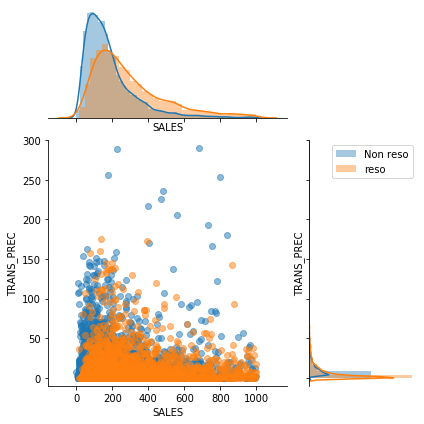

In [7]:
dati_grafico = X[["SALES", "TRANS_PREC"]].copy()
dati_grafico['RESO'] = y.values
dati_grafico.dropna(inplace=True)

g = sns.JointGrid("SALES", "TRANS_PREC", dati_grafico, ratio=2, height=6, space=0.2, ylim=[-10, 300])

for i, gr in dati_grafico.groupby("RESO"):
    sns.distplot(gr["SALES"], ax=g.ax_marg_x)
    sns.distplot(gr["TRANS_PREC"], ax=g.ax_marg_y, vertical=True)
    g.ax_joint.plot(gr["SALES"], gr["TRANS_PREC"], 'o', alpha=0.5)
plt.legend(["Non reso", "reso"])
plt.show()

C:\Users\Lorenzo\anaconda3\envs\msbd\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Lorenzo\anaconda3\envs\msbd\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


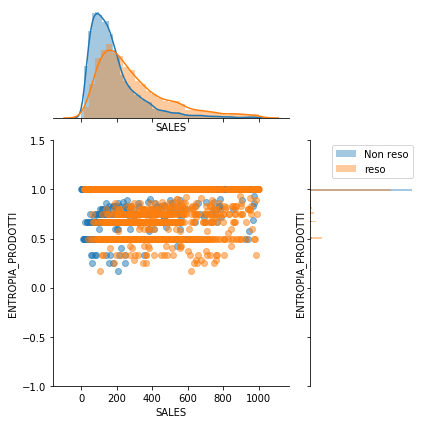

In [8]:
dati_grafico = X[["SALES", "ENTROPIA_PRODOTTI"]].copy()
dati_grafico['RESO'] = y.values
dati_grafico.dropna(inplace=True)

g = sns.JointGrid("SALES", "ENTROPIA_PRODOTTI", dati_grafico, ratio=2, height=6, space=0.2, ylim=[-1,1.5])

for i, gr in dati_grafico.groupby("RESO"):
    sns.distplot(gr["SALES"], ax=g.ax_marg_x)
    sns.distplot(gr["ENTROPIA_PRODOTTI"], ax=g.ax_marg_y, vertical=True)
    g.ax_joint.plot(gr["SALES"], gr["ENTROPIA_PRODOTTI"], 'o', alpha=0.5)
plt.legend(["Non reso", "reso"])
plt.show()

### 2.2 Confronto grafico tra variabili categoriali e continue

In questa sezione produciamo qualche grafico (es. `sns.boxplot`) tra coppie di variabili categoriali/continue.

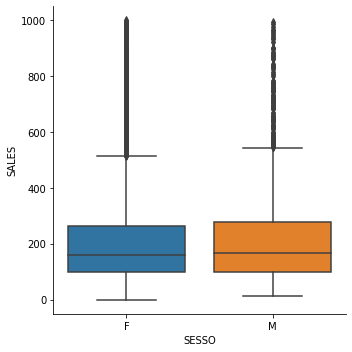

In [9]:
sns.catplot(x="SESSO", y="SALES", kind="box", data=X).set_xticklabels(["F", "M"])

In [10]:
dati["NAZIONE"].unique()

array(['Altro Europa', 'Italy', 'Netherlands', 'Germany', 'Poland',
       'United Kingdom', 'Denmark', 'France', 'Belgium',
       'Russian Federation', 'United States', 'Austria'], dtype=object)

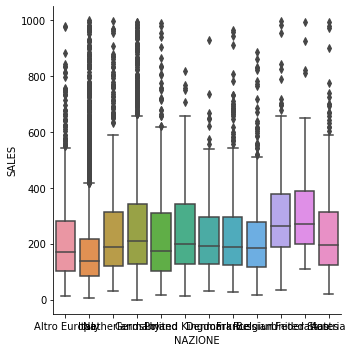

In [11]:
sns.catplot(x="NAZIONE", y="SALES", kind="box", data=X).set_xticklabels(list(dati["NAZIONE"].unique()))

### 2.3 Confronto grafico tra % resi e variabili esplicative

In questa sezione produciamo qualche grafico (es. `sns.boxplot`) tra la variabile risposta dicotomica "RESO" e le variabili continue del dataset.

In [ ]:
sns.boxplot(y, X["ENTROPIA_PRODOTTI"])

In [ ]:
sns.boxplot(y, X["PRODOTTI_DISTINTI"])

## 3. Preprocessing dei dati

### 3.1 Selezione e trasformazione delle variabili

In questa sezione ci occupiamo di trasformare il dato originale in un formato adatto ad alimentare un modello di classificazione:
* individuiamo trasformazioni sensate di `DATAORDINE`
* `RESI_PREC` per definizione è sempre minore o uguale a `TRANS_PREC`. Come si potrebbe trasformare per dargli un significato?
* se `FREESHIPPING=1` allora `SPESE_DI_SPEDIZIONE=0`. Ha senso tenere entrambe le variabili per l'analisi?

In [4]:
from datetime import datetime
dateFormatter = "%Y-%m-%d"
for i in range(0,len(X["DATAORDINE"])):
    X["DATAORDINE"][i] = datetime.strptime(X["DATAORDINE"][i], dateFormatter).month
X.head()

C:\Users\Lorenzo\anaconda3\envs\msbd\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,QTA,SALES,CATEGORIE_DISTINTE,ENTROPIA_CATEGORIE,PRODOTTI_DISTINTI,ENTROPIA_PRODOTTI,RECORD,FIT,STAGIONE,DATAORDINE,SCONTO,FREESHIPPING,PAGAMENTO,SPESE_DI_SPEDIZIONE,SESSO,NAZIONE,RESI_PREC,TRANS_PREC
0,1,297.541667,1,1.000000,1,1.0,1,3,20123,4,0,0,Cash,7,F,Altro Europa,1,10
1,2,134.500000,2,1.000000,2,1.0,2,4,20133,1,1,1,Paypal,0,F,Italy,3,28
2,3,326.366667,2,0.666667,3,1.0,3,6,20133,2,1,0,Credit card,12,F,Netherlands,19,56
3,3,272.000000,1,0.333333,3,1.0,3,6,20113,9,1,0,Cash,9,F,Germany,0,21
4,1,35.500000,1,1.000000,1,1.0,1,2,20102,1,1,1,Credit card,0,F,Italy,0,0


In [5]:
X = X.drop(columns=["FREESHIPPING"])
X.head()

,QTA,SALES,CATEGORIE_DISTINTE,ENTROPIA_CATEGORIE,PRODOTTI_DISTINTI,ENTROPIA_PRODOTTI,RECORD,FIT,STAGIONE,DATAORDINE,SCONTO,PAGAMENTO,SPESE_DI_SPEDIZIONE,SESSO,NAZIONE,RESI_PREC,TRANS_PREC
0,1,297.541667,1,1.000000,1,1.0,1,3,20123,4,0,Cash,7,F,Altro Europa,1,10
1,2,134.500000,2,1.000000,2,1.0,2,4,20133,1,1,Paypal,0,F,Italy,3,28
2,3,326.366667,2,0.666667,3,1.0,3,6,20133,2,1,Credit card,12,F,Netherlands,19,56
3,3,272.000000,1,0.333333,3,1.0,3,6,20113,9,1,Cash,9,F,Germany,0,21
4,1,35.500000,1,1.000000,1,1.0,1,2,20102,1,1,Credit card,0,F,Italy,0,0


In [6]:
perc_resi = []
for i in range(0, len(X["RESI_PREC"])):
    if X["TRANS_PREC"][i] > 0:
        perc_resi.append(X["RESI_PREC"][i]/X["TRANS_PREC"][i])
    else:
        perc_resi.append(0)
X["RESI_PREC"] = perc_resi   

### 3.2 Creazione delle variabili dummy e standardizzazione

Suggerimenti:
* Trasformate esplicitamente nel tipo `object` le variabili che ritenete categoriali: `dataframe[nomecampo] = dataframe[nomecampo].astype("object")`.
* Trasformate (**solo**) le variabili categoriali in dummy; ricordate poi di "riattaccare" le colonne numeriche al dataset. Potete usare [get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html).
* Normalizzate le variabili ([esempio1](http://www.andreaminini.com/python/sklearn/standardscaler-su-scikit-learn), [esempio2](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)).

In [7]:
categorie = ['STAGIONE','DATAORDINE','SCONTO','PAGAMENTO','SESSO','NAZIONE']
X[categorie] = X[categorie].astype("object")

In [8]:
from msbd.preprocessamento import OttenereDummy

X2 = X.copy()

od = OttenereDummy(drop_first=True)

X = od.fit_transform(X)
X.head()

,QTA,SALES,CATEGORIE_DISTINTE,ENTROPIA_CATEGORIE,PRODOTTI_DISTINTI,ENTROPIA_PRODOTTI,RECORD,FIT,SPESE_DI_SPEDIZIONE,RESI_PREC,...,NAZIONE_Belgium,NAZIONE_Denmark,NAZIONE_France,NAZIONE_Germany,NAZIONE_Italy,NAZIONE_Netherlands,NAZIONE_Poland,NAZIONE_Russian Federation,NAZIONE_United Kingdom,NAZIONE_United States
0,1.0,297.541667,1.0,1.000000,1.0,1.0,1.0,3.0,7.0,0.100000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,134.500000,2.0,1.000000,2.0,1.0,2.0,4.0,0.0,0.107143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,3.0,326.366667,2.0,0.666667,3.0,1.0,3.0,6.0,12.0,0.339286,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3.0,272.000000,1.0,0.333333,3.0,1.0,3.0,6.0,9.0,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,35.500000,1.0,1.000000,1.0,1.0,1.0,2.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [9]:
from msbd.preprocessamento import Standardizzare

X3 = X.copy()
std = Standardizzare()
X = std.fit_transform(X)
X.head()

,QTA,SALES,CATEGORIE_DISTINTE,ENTROPIA_CATEGORIE,PRODOTTI_DISTINTI,ENTROPIA_PRODOTTI,RECORD,FIT,SPESE_DI_SPEDIZIONE,RESI_PREC,...,NAZIONE_Belgium,NAZIONE_Denmark,NAZIONE_France,NAZIONE_Germany,NAZIONE_Italy,NAZIONE_Netherlands,NAZIONE_Poland,NAZIONE_Russian Federation,NAZIONE_United Kingdom,NAZIONE_United States
0,-0.637238,0.538068,-0.588619,0.523082,-0.614451,0.29352,-0.638689,-0.199246,-0.019096,-0.209495,...,-0.192808,-0.109745,-0.184604,-0.482088,-1.055294,-0.247871,-0.190637,-0.11394,-0.11394,-0.087948
1,0.109484,-0.453435,0.577614,0.523082,0.213603,0.29352,0.117913,0.152306,-1.576216,-0.183664,...,-0.192808,-0.109745,-0.184604,-0.482088,0.947536,-0.247871,-0.190637,-0.11394,-0.11394,-0.087948
2,0.856207,0.713361,0.577614,-1.145483,1.041657,0.29352,0.874514,0.855411,1.093133,0.655821,...,-0.192808,-0.109745,-0.184604,-0.482088,-1.055294,4.034079,-0.190637,-0.11394,-0.11394,-0.087948
3,0.856207,0.382742,-0.588619,-2.814047,1.041657,0.29352,0.874514,0.855411,0.425796,-0.571119,...,-0.192808,-0.109745,-0.184604,2.074165,-1.055294,-0.247871,-0.190637,-0.11394,-0.11394,-0.087948
4,-0.637238,-1.055482,-0.588619,0.523082,-0.614451,0.29352,-0.638689,-0.550799,-1.576216,-0.571119,...,-0.192808,-0.109745,-0.184604,-0.482088,0.947536,-0.247871,-0.190637,-0.11394,-0.11394,-0.087948


### 3.3 Divisione del dataset in training e validation set

Dividete sia il dataset trasformato delle variabili indipendenti X che la variabile dipendente y in *training set* e *validation set* sulla base del valore del campo `train` (training set identificato da `train=0`).

Il *training set* sarà usato per la stima dei modelli, il *validation set* per determinare la bontà della previsione.

In [10]:
X_train = X[dati["train"] == 0]
y_train = y[dati["train"] == 0]
X_val = X[dati["train"] == 1]
y_val = y[dati["train"] == 1]

## 4. Modelli di classificazione

In questa sezione proveremo alcuni modelli di classificazione:
* DummyClassifier
* DecisionTreeClassifier "standard", ovvero con parametri di default
* DecisionTreeClassifier con ottimizzazione degli iperparametri di default

Selezionare il modello che fornisce la percentuale maggiore di accuratezza della classificazione.
La accuratezza totale si può facilmente ottenere con la funzione `sklearn.metrics.accuracy_score`. Per avere informazioni più dettagliate, si usi`sklearn.metrics.classification_report`.

### 4.1 Dummy classifier

In [11]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

dc = DummyClassifier("most_frequent")

dc.fit(X_train, y_train)

y_pred = dc.predict(X_val)
dc_acc = accuracy_score(y_val, y_pred)

print('Accuratezza DummyClassifier("most_frequent"): {:.1f}%'.format(100 * dc_acc))

mc = confusion_matrix(y_val, y_pred, labels=[0,1])
print("\nMatrice di confusione DummyClassifier: \n {}".format(mc))

cr = classification_report(y_val, y_pred, output_dict=False)
print("\nReport di classificazione DummyClassifier: \n {}".format(cr))

Accuratezza DummyClassifier("most_frequent"): 79.4%

Matrice di confusione DummyClassifier: 
 [[3427    0]
 [ 891    0]]

Report di classificazione DummyClassifier: 
               precision    recall  f1-score   support

           0       0.79      1.00      0.88      3427
           1       0.00      0.00      0.00       891

    accuracy                           0.79      4318
   macro avg       0.40      0.50      0.44      4318
weighted avg       0.63      0.79      0.70      4318



C:\Users\Lorenzo\anaconda3\envs\msbd\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 4.2 Decision tree classifier

Si provi a visualizzare l'albero di classificazione ottenuto. Qual è la variabile che determina il primo split?

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

dtc = DecisionTreeClassifier()

dtc.fit(X_train, y_train)

y_pred = dtc.predict(X_val)

dtc_acc = accuracy_score(y_val, y_pred)

print('Accuratezza DummyClassifier("most_frequent"): {:.1f}%'.format(100 * dc_acc))
print("Accuratezza DecisionTreeClassifier(): {:.1f}%".format(100 * dtc_acc))

mc = confusion_matrix(y_val, y_pred, labels=[0,1])
print("\nMatrice di confusione DecisionTreeClassifier: \n {}".format(mc))

cr = classification_report(y_val, y_pred, output_dict=False)
print("\nReport di classificazione DecisionTreeClassifier: \n {}".format(cr))

Accuratezza DummyClassifier("most_frequent"): 79.4%
Accuratezza DecisionTreeClassifier(): 76.5%

Matrice di confusione DecisionTreeClassifier: 
 [[2826  601]
 [ 414  477]]

Report di classificazione DecisionTreeClassifier: 
               precision    recall  f1-score   support

           0       0.87      0.82      0.85      3427
           1       0.44      0.54      0.48       891

    accuracy                           0.76      4318
   macro avg       0.66      0.68      0.67      4318
weighted avg       0.78      0.76      0.77      4318



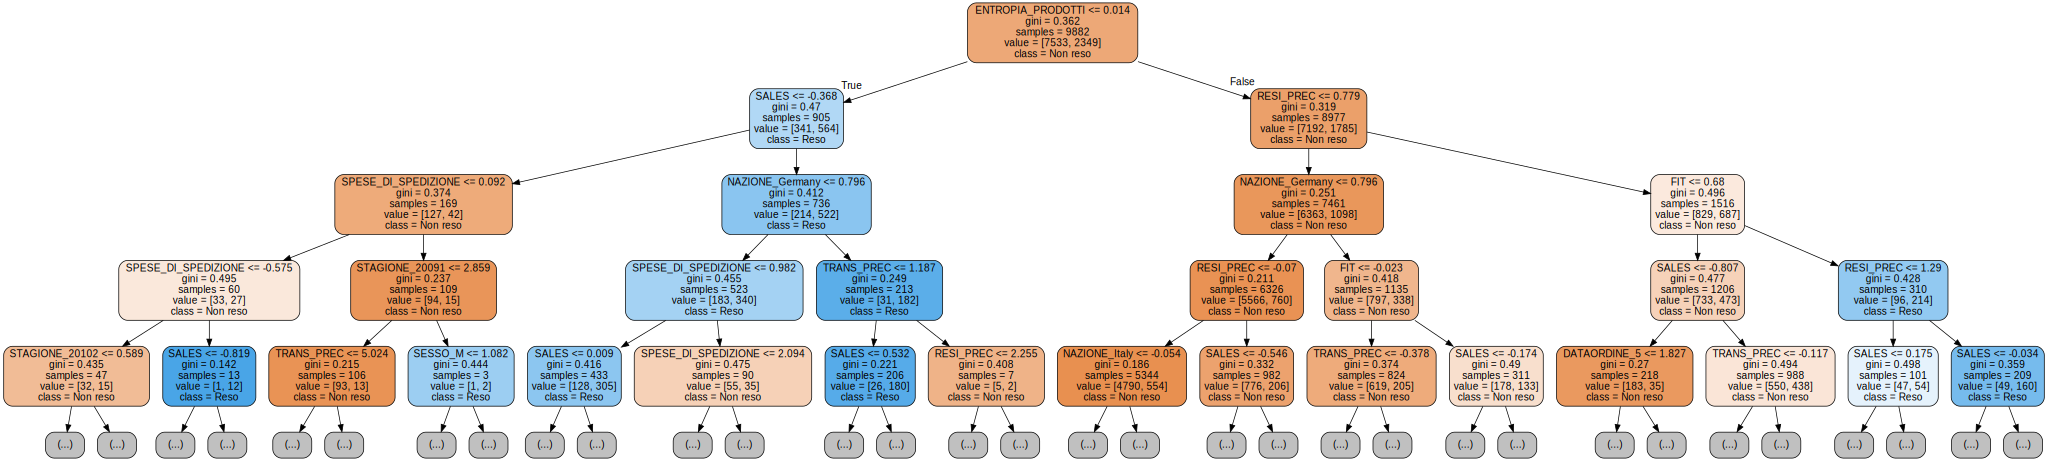

In [13]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(
    decision_tree=dtc, 
    max_depth=4,
    feature_names=X_train.columns,
    class_names=("Non reso", "Reso"),
    filled=True,
    rounded=True,
)
display(graphviz.Source(dot_data))

Si definisca una griglia di iperparametri (`max_depth`, `min_samples_leaf`, `min_impurity_decrease`) per cercare la combinazione che fornisce la `accuracy` più alta. Usare questi valori dei parametri per inizializzare la classe `DecisionTreeClassifier`.

In [14]:
from sklearn.model_selection import ParameterGrid
import tqdm

In [15]:
print("Profondità dell'albero allenato senza restrizioni: {}".format(dtc.max_depth))
print("Massimo numero minimo di osservazioni in una foglia: {}".format(len(X_train) // 2))
print("minimo incremeto di impurità: {}".format(dtc.min_impurity_decrease))

Profondità dell'albero allenato senza restrizioni: None
Massimo numero minimo di osservazioni in una foglia: 4941
minimo incremeto di impurità: 0.0


In [16]:
param_grid = ParameterGrid({
    'max_depth': np.arange(1, 19),
    'min_samples_leaf': 2 ** np.arange(9)
    'min_impurity_decrease': [1]
    
})
print(param_grid.param_grid)
risultati = []

for params in tqdm.tqdm(param_grid):
    dtc.set_params(**params)
    dtc.fit(X_train, y_train)
    y_pred = dtc.predict(X_val)
    params["accuracy_score"] = accuracy_score(y_val, y_pred)
    risultati.append(params)

risultati = pd.DataFrame(risultati).sort_values(["accuracy_score", "max_depth"], ascending=[False, True])
risultati.reset_index(drop=True, inplace=True)
print("Primi 5:")
display(risultati.head())

print("Ultimi 5:")
display(risultati.tail())

  6%|█████                                                                            | 10/162 [00:00<00:01, 94.52it/s]

[{'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18]), 'min_samples_leaf': array([  1,   2,   4,   8,  16,  32,  64, 128, 256], dtype=int32)}]


100%|████████████████████████████████████████████████████████████████████████████████| 162/162 [00:06<00:00, 23.83it/s]

Primi 5:


,max_depth,min_samples_leaf,accuracy_score
0,6,4,0.863363
1,6,32,0.862899
2,7,16,0.862668
3,6,16,0.862205
4,8,32,0.861510


Ultimi 5:


,max_depth,min_samples_leaf,accuracy_score
157,18,4,0.803613
158,18,2,0.801992
159,16,1,0.797591
160,17,1,0.795044
161,18,1,0.791339


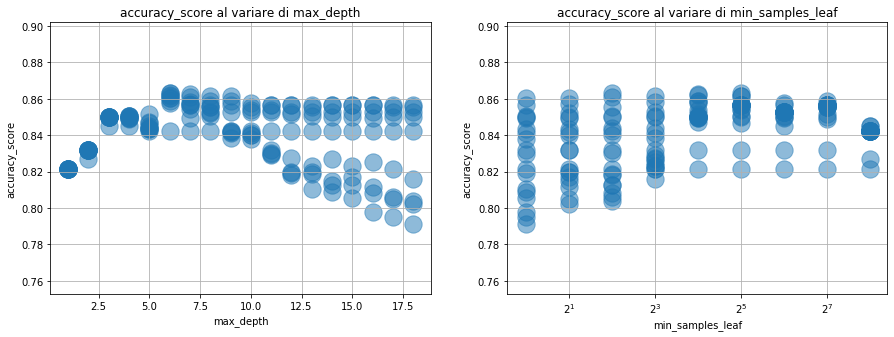

In [20]:
from msbd.grafici import grafico_metrica_iperparametro

plt.figure(figsize=(15, 5))

plt.subplot(121)
grafico_metrica_iperparametro(risultati, "max_depth", "accuracy_score", alpha=0.5)

plt.subplot(122)
grafico_metrica_iperparametro(risultati, "min_samples_leaf", "accuracy_score", alpha=0.5)
plt.xscale("log", basex=2)


plt.show()

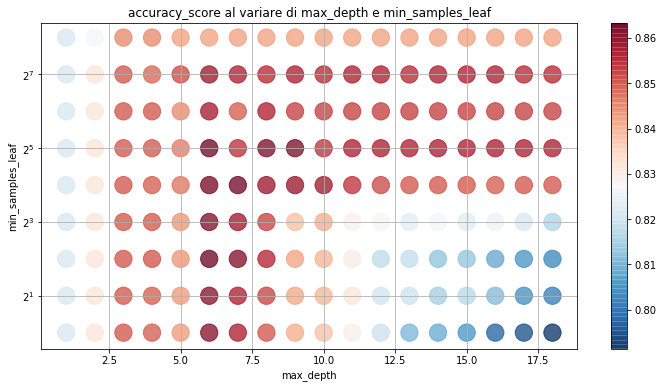

In [21]:
from msbd.grafici import grafico_metrica_iperparametri

plt.figure(figsize=(12, 6))

grafico_metrica_iperparametri(risultati, "max_depth", "min_samples_leaf", "accuracy_score")
plt.yscale("log", basey=2)

plt.show()

In [25]:
max_depth = risultati.loc[0, "max_depth"]
min_samples_leaf = risultati.loc[0, "min_samples_leaf"]

dtc_tun = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)

dtc_tun.fit(X_train, y_train)

y_pred = dtc_tun.predict(X_val)
dtc_tun_acc = accuracy_score(y_val, y_pred)

print('Accuratezza DummyClassifier("most_frequent"): {:.1f}%'.format(100 * dc_acc))
print("Accuratezza DecisionTreeClassifier(): {:.1f}%".format(100 * dtc_acc))
print("Accuratezza DecisionTreeClassifier(max_depth={}, min_samples_leaf={}): {:.1f}%".format(
    max_depth, min_samples_leaf, 100 * dtc_tun_acc))

mc = confusion_matrix(y_val, y_pred, labels=[0,1])
print("\nMatrice di confusione DecisionTreeClassifier(max_depth={}, min_samples_leaf={}): \n {}".format(max_depth, min_samples_leaf, mc))

cr = classification_report(y_val, y_pred, output_dict=False)
print("\nReport di classificazione DecisionTreeClassifier(max_depth={}, min_samples_leaf={}): \n {}".format(max_depth, min_samples_leaf, cr))

Accuratezza DummyClassifier("most_frequent"): 79.4%
Accuratezza DecisionTreeClassifier(): 76.5%
Accuratezza DecisionTreeClassifier(max_depth=6, min_samples_leaf=4): 86.3%

Matrice di confusione DecisionTreeClassifier(max_depth=6, min_samples_leaf=4): 
 [[3326  101]
 [ 489  402]]

Report di classificazione DecisionTreeClassifier(max_depth=6, min_samples_leaf=4): 
               precision    recall  f1-score   support

           0       0.87      0.97      0.92      3427
           1       0.80      0.45      0.58       891

    accuracy                           0.86      4318
   macro avg       0.84      0.71      0.75      4318
weighted avg       0.86      0.86      0.85      4318



In [23]:
max_depth = risultati.loc[0, "max_depth"]
min_samples_leaf = risultati.loc[0, "min_samples_leaf"]

dtc_tun = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)

dtc_tun.fit(X_train, y_train)

y_pred = dtc_tun.predict(X_train)
dtc_tun_acc = accuracy_score(y_train, y_pred)

print('Accuratezza DummyClassifier("most_frequent"): {:.1f}%'.format(100 * dc_acc))
print("Accuratezza DecisionTreeClassifier(): {:.1f}%".format(100 * dtc_acc))
print("Accuratezza DecisionTreeClassifier(max_depth={}, min_samples_leaf={}): {:.1f}%".format(
    max_depth, min_samples_leaf, 100 * dtc_tun_acc))

mc = confusion_matrix(y_train, y_pred, labels=[0,1])
print("\nMatrice di confusione DecisionTreeClassifier(max_depth={}, min_samples_leaf={}): \n {}".format(max_depth, min_samples_leaf, mc))

cr = classification_report(y_train, y_pred, output_dict=False)
print("\nReport di classificazione DecisionTreeClassifier(max_depth={}, min_samples_leaf={}): \n {}".format(max_depth, min_samples_leaf, cr))

Accuratezza DummyClassifier("most_frequent"): 79.4%
Accuratezza DecisionTreeClassifier(): 76.5%
Accuratezza DecisionTreeClassifier(max_depth=6, min_samples_leaf=4): 82.3%

Matrice di confusione DecisionTreeClassifier(max_depth=6, min_samples_leaf=4): 
 [[7261  272]
 [1474  875]]

Report di classificazione DecisionTreeClassifier(max_depth=6, min_samples_leaf=4): 
               precision    recall  f1-score   support

           0       0.83      0.96      0.89      7533
           1       0.76      0.37      0.50      2349

    accuracy                           0.82      9882
   macro avg       0.80      0.67      0.70      9882
weighted avg       0.81      0.82      0.80      9882



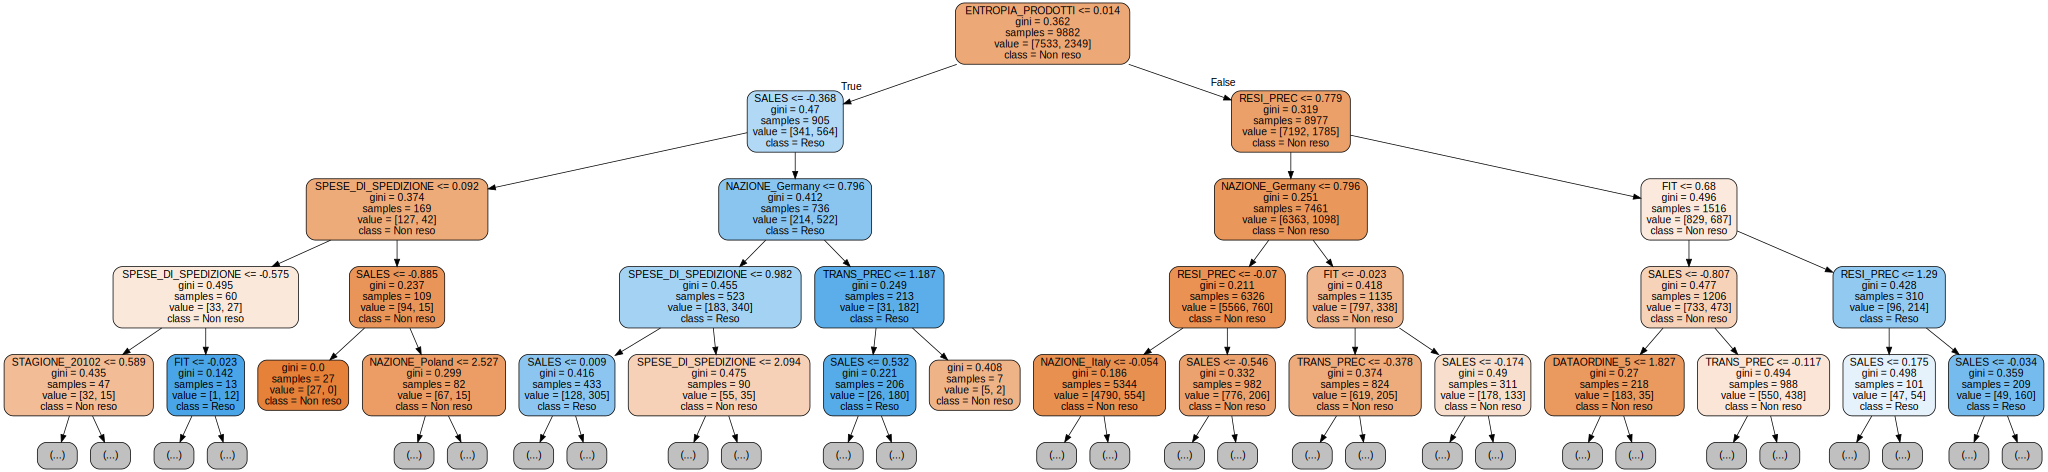

In [52]:
dot_data = export_graphviz(
    decision_tree=dtc_tun, 
    max_depth=4,
    feature_names=X_train.columns,
    class_names=("Non reso", "Reso"),
    filled=True,
    rounded=True,
)
display(graphviz.Source(dot_data))

In [ ]:
from msbd.grafici import grafico_importanza_variabili

importanze = dtc_tun.feature_importances_
variabili = X_train.columns

grafico_importanza_variabili(importanze, variabili)

plt.show()

## 5. Business game

Scegliete il classificatore con le migliori performance. Le previsioni del modello vanno valutate su diversi scenari, calcolando l'impatto economico sui dati del *validation set*:

* Scenario 1: Concedere il reso gratuito a tutti i clienti (perdita pari al costo dei resi)
* Scenario 2: Concedere il reso gratuito ai soli *clienti ad alto valore* (definizione qui sotto)
* Scenario 3: Concedere il reso gratuito "[a caso](https://het.as.utexas.edu/HET/Software/Numpy/reference/generated/numpy.random.choice.html)" con il lancio di una monetina
* Scenario 4: Concedere il reso gratuito sulla base dell'output del modello (se output=="Non reso" allora diamo il reso gratuito)

Per ogni scenario dobbiamo calcolare potenziali bonus o perdite:
- un *reso non previsto* (falso negativo) ci **costa 20€** (costi di riassortimento del magazzino) se concediamo il reso gratuito;
- un *cliente ad alto valore che non rende il pacco ma a cui non diamo il reso gratuito* comporta una **perdita stimata in 40€** (per ciascun ordine). Nel caso in cui lo restituisca, non ho nessuna perdita stimata;
- un *cliente a basso valore che rende il pacco, a cui concediamo il reso gratuito* (vero reso, basso valore) ha un **effetto positivo stimato in 15€** (per ciascun ordine).

Identifichiamo come **clienti ad alto valore** quelli con **almeno 5 transazioni precedenti**. Il consiglio è di creare una colonna ad-hoc per questa nuova variabile. 

Al momento, la scelta dell'azienda consiste nel concedere il reso gratuito solo a questi clienti: vogliamo capire affidandoci al responso del modello siamo in grado di ridurre i costi di reso del nostro ecommerce.

### 5.1 Identificazione dei clienti ad alto valore

Suggerimento: una volta creata la nuova variabile relativa al valore cliente, costruire un `pandas DataFrame` con: valore cliente, y osservata e y prevista dal modello.

Potete usare la notazione:

`
NOME_DATAFRAME = pd.DataFrame({"valore_cliente": X_val["VALORE CLIENTE"], "y_val": y_val, "y_pred": y_pred})
`

Per "filtrare" il DataFrame rispetto ai valori assunti dai suoi campi, usare [loc](https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/#loc-selection) (paragrafo *2b. Boolean / Logical indexing using .loc*).

In [26]:
X4 = dati[dati["train"]==1]
valore = (X4["TRANS_PREC"]>5).astype('int')
X_game = pd.DataFrame({"valore_cliente": valore, "y_val": y_val, "y_pred": y_pred})
X_game = X_game.reset_index(drop=True)

### 5.2 Bilancio benefici-costi per ogni scenario

Consiglio: dichiarare tre variabili con i valori monetari associati a: 
* costo del reso
* mancati guadagni per clienti ad alto valore
* bonus guadagni per clienti a basso valore

e calcolare per ogni scenario la perdita derivante da queste impostazioni.

In [28]:
X_game["y_pred"] = y_pred
costo_reso = 20
mancati = 40
bonus = 15
costo_totale_reso = 0
mancati_totale = 0
bonus_totale = 0
for i in range(0, len(y_val)):
    if (X_game["y_val"][i]==1 and X_game['y_pred'][i]==0):
        costo_totale_reso += costo_reso
for i in range(0, len(y_val)):
    if (X_game["valore_cliente"][i]==1 and X_game["y_val"][i]==0 and X_game["y_pred"][i]==1):
        mancati_totale += mancati
for i in range(0, len(y_val)):
    if (X_game["valore_cliente"][i]==0 and X_game["y_val"][i]==1 and X_game["y_pred"][i]==0):
        bonus_totale += bonus
print(costo_totale_reso, mancati_totale, bonus_totale)
print(- costo_totale_reso - mancati_totale + bonus_totale)

9780 1640 5025
-6395


In [29]:
for i in range(0, len(X_game["y_pred"])):
    if X_game["valore_cliente"][i]==1 :
        X_game.loc[i, "y_pred"] = 0
    else:
        X_game.loc[i, "y_pred"] = 1       
costo_totale_reso = 0
mancati_totale = 0
bonus_totale = 0
for i in range(0, len(y_val)):
    if (X_game["y_val"][i]==1 and X_game['y_pred'][i]==0):
        costo_totale_reso += costo_reso
for i in range(0, len(y_val)):
    if (X_game["valore_cliente"][i]==1 and X_game["y_val"][i]==0 and X_game["y_pred"][i]==1):
        mancati_totale += mancati
for i in range(0, len(y_val)):
    if (X_game["valore_cliente"][i]==0 and X_game["y_val"][i]==1 and X_game["y_pred"][i]==0):
        bonus_totale += bonus
print(costo_totale_reso, mancati_totale, bonus_totale)
print(- costo_totale_reso - mancati_totale + bonus_totale)

6860 0 0
-6860


In [30]:
X_game["y_pred"] = 0
costo_totale_reso = 0
mancati_totale = 0
bonus_totale = 0
for i in range(0, len(y_val)):
    if (X_game["y_val"][i]==1 and X_game['y_pred'][i]==0):
        costo_totale_reso += costo_reso
for i in range(0, len(y_val)):
    if (X_game["valore_cliente"][i]==1 and X_game["y_val"][i]==0 and X_game["y_pred"][i]==1):
        mancati_totale += mancati
for i in range(0, len(y_val)):
    if (X_game["valore_cliente"][i]==0 and X_game["y_val"][i]==1 and X_game["y_pred"][i]==0):
        bonus_totale += bonus
print(costo_totale_reso, mancati_totale, bonus_totale)
print(- costo_totale_reso - mancati_totale + bonus_totale)

17820 0 8220
-9600


In [31]:
import random
random.seed(142)
X_game["y_pred"] = np.random.choice(2,len(y_val))
costo_totale_reso = 0
mancati_totale = 0
bonus_totale = 0
for i in range(0, len(y_val)):
    if (X_game["y_val"][i]==1 and X_game['y_pred'][i]==0):
        costo_totale_reso += costo_reso
for i in range(0, len(y_val)):
    if (X_game["valore_cliente"][i]==1 and X_game["y_val"][i]==0 and X_game["y_pred"][i]==1):
        mancati_totale += mancati
for i in range(0, len(y_val)):
    if (X_game["valore_cliente"][i]==False and X_game["y_val"][i]==1 and X_game["y_pred"][i]==0):
        bonus_totale += bonus
print(costo_totale_reso, mancati_totale, bonus_totale)
print(- costo_totale_reso - mancati_totale + bonus_totale)

9260 18840 4290
-23810


### 5.3 Calcolo del break even di progetto

L'area Pianificazione Strategica vuole calcolare il punto di pareggio di questo progetto rispetto allo scenario 2 adottato finora, se siamo riusciti a migliorarlo.

Il *costo* della messa in produzione del modello (specificazione del modello, test, deploy e modifiche al sito web di e-commerce, ecc...) è valutato in **7000€**.

Considerando una distribuzione reale di ordini/mese uniforme nel tempo e pari a 15 volte quella descritta dal dataset che abbiamo analizzato, a quanti mesi **stimiamo il punto di pareggio**? 

In [32]:
costo = 7000
perdita2 = -6860
perdita4 = -6395
perdita2 * 15 - perdita4 * 15

-6975